## fetching data from my spotify api

we have our client id and secret created on spotify developer page. we will be using spotipy liberary to fetch data and will authenticate it.

In [1]:
import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import calendar
from sklearn.decomposition import PCA
sns.set()

## Data Scraping

In [2]:
## here we are opening our external file with credentials

In [3]:
f = open("C:\\Users\Dream\codeop\spotify\credentials","r")
CLIENT_ID = f.readline().replace('\n','')
CLIENT_SECRET = f.readline().replace('\n','')

In [4]:
##  authorization of our API

In [5]:
## To authorize your API calls without going through the headache of verifying 
## the redirect URL. Just make use of the oauth2 method:

credentials = oauth2.SpotifyClientCredentials( client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)


C:\Users\Dream\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  """


In [6]:
## in the next cell we are going to create a function to fetch data using 
## spotify special functions. we nee audio features in our playlist and thats what is important for our analysis

In [7]:
# Function to get song features from a playlist
def get_playlist_songs(username, playlist_id):
    # Get songs from playlist
    playlist = spotify.user_playlist_tracks(username, playlist_id)
    songs = playlist['items']
    while playlist['next']:
        playlist = spotify.next(playlist) # use sp.next method to overcome fetch limit of 100 songs
        songs.extend(playlist['items'])
    # Create a list with song ids
    song_ids = [] 
    for i in range(len(songs)): 
        song_ids.append(songs[i]["track"]["id"]) 
    # Create a dataframe with features for each song
    songs_df = pd.DataFrame()
    for song_id in song_ids:
        features = spotify.audio_features(song_id) 
        songs_df = songs_df.append(pd.DataFrame(features), ignore_index=True)
    return songs_df

In [8]:
liked_songs = get_playlist_songs("my_playlist", "https://open.spotify.com/playlist/0zx34QBjFUJfy5V9Nxnaxy?si=zvF66wCXSFi_ycr03m1iJw")
print(liked_songs.shape)
#print(liked_songs.info())
liked_songs.head(2)

(599, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.358,0.920,6,-2.843,1,0.2180,0.00013,0.0118,0.0765,0.493,99.919,audio_features,3HtCaD8SkNbjy3TrEcS4Km,spotify:track:3HtCaD8SkNbjy3TrEcS4Km,https://api.spotify.com/v1/tracks/3HtCaD8SkNbj...,https://api.spotify.com/v1/audio-analysis/3HtC...,241547,4
1,0.599,0.845,10,-4.100,0,0.0446,0.30200,0.0000,0.0734,0.485,150.032,audio_features,1EBDy7MWZ3GRyFBduP5QVg,spotify:track:1EBDy7MWZ3GRyFBduP5QVg,https://api.spotify.com/v1/tracks/1EBDy7MWZ3GR...,https://api.spotify.com/v1/audio-analysis/1EBD...,351504,4


In [9]:
disliked_songs = get_playlist_songs("no_playlist", "https://open.spotify.com/playlist/1PRbKkKbUN7O2BJjRL7QRv?si=D8q5THQrSbyWp9u2YipRuw")
print(disliked_songs.shape)
#print(disliked_songs.info())
disliked_songs.head(2)

(400, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.685,0.329,8,-10.159,1,0.875,0.623,0.0,0.3850,0.698,86.993,audio_features,1k3xls4mMxRv5do5nkun3S,spotify:track:1k3xls4mMxRv5do5nkun3S,https://api.spotify.com/v1/tracks/1k3xls4mMxRv...,https://api.spotify.com/v1/audio-analysis/1k3x...,87185,5
1,0.762,0.658,1,-3.423,0,0.136,0.358,0.0,0.0885,0.389,130.003,audio_features,5YcPaD42EIHnDSDE5FT5Xe,spotify:track:5YcPaD42EIHnDSDE5FT5Xe,https://api.spotify.com/v1/tracks/5YcPaD42EIHn...,https://api.spotify.com/v1/audio-analysis/5YcP...,167539,4


In [10]:
validation_set = get_playlist_songs("validation1", "https://open.spotify.com/playlist/5z8Feij4DTtjwoAJliL01O?si=PJTyQ-J_TUS5O69Oj9ze8A")
print(validation_set.shape)
#print(validation_set.info())
validation_set.head(2)

(30, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.554,0.321,9,-8.251,1,0.0280,0.89300,0.000000,0.0996,0.288,135.047,audio_features,6QPKYGnAW9QozVz2dSWqRg,spotify:track:6QPKYGnAW9QozVz2dSWqRg,https://api.spotify.com/v1/tracks/6QPKYGnAW9Qo...,https://api.spotify.com/v1/audio-analysis/6QPK...,285240,4
1,0.603,0.670,2,-3.882,0,0.0249,0.00408,0.000002,0.1120,0.445,107.995,audio_features,5PKWUDfQFtc5qqo8cs1gQp,spotify:track:5PKWUDfQFtc5qqo8cs1gQp,https://api.spotify.com/v1/tracks/5PKWUDfQFtc5...,https://api.spotify.com/v1/audio-analysis/5PKW...,242974,4


In [11]:
random_set = get_playlist_songs("validation2", "https://open.spotify.com/playlist/4stUENVtDPmh9tZ54U6eUS?si=HD2wmT87Ss2IypacU28YUw")
print(random_set.shape)
#print(random_set.info())
random_set.head(2)

(30, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.713,0.963,7,-3.979,1,0.120,0.2470,0.0,0.125,0.631,123.820,audio_features,4KkzkMg3wMqezfHYNPlVy8,spotify:track:4KkzkMg3wMqezfHYNPlVy8,https://api.spotify.com/v1/tracks/4KkzkMg3wMqe...,https://api.spotify.com/v1/audio-analysis/4Kkz...,208533,4
1,0.773,0.922,7,-3.416,1,0.211,0.0619,0.0,0.347,0.527,105.524,audio_features,5UvhJ4hZDaqIB95NixkzsR,spotify:track:5UvhJ4hZDaqIB95NixkzsR,https://api.spotify.com/v1/tracks/5UvhJ4hZDaqI...,https://api.spotify.com/v1/audio-analysis/5Uvh...,200160,4


In [12]:
## we are going to create our target column where 0 means i do not like the song whereas 1 means i like it.

In [13]:
disliked_songs['target'] = 0
liked_songs['target'] = 1
validation_liked_songs['Discover'] = 1
validation_disliked_songs['Discover'] = 0

In [14]:
liked_songs['target'] = 1

In [15]:
validation_liked_songs['Discover'] = 1

In [16]:
validation_disliked_songs['Discover'] = 0

In [17]:
df = pd.concat([liked_songs,disliked_songs], axis = 0).reset_index(drop=True)
val = pd.concat([validation_set,random_set], axis = 0).reset_index(drop=True)


In [18]:
val = pd.concat([validation_set,random_set], axis = 0).reset_index(drop=True)


## EDA (exploratry Data Analysis) 
#### with data cleaning, transformation

In [19]:
print(df.shape)
df.head()

(999, 19)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,target
0,0.358,0.920,6,-2.843,1,0.2180,0.00013,0.011800,0.0765,0.493,99.919,audio_features,3HtCaD8SkNbjy3TrEcS4Km,spotify:track:3HtCaD8SkNbjy3TrEcS4Km,https://api.spotify.com/v1/tracks/3HtCaD8SkNbj...,https://api.spotify.com/v1/audio-analysis/3HtC...,241547,4,1
1,0.599,0.845,10,-4.100,0,0.0446,0.30200,0.000000,0.0734,0.485,150.032,audio_features,1EBDy7MWZ3GRyFBduP5QVg,spotify:track:1EBDy7MWZ3GRyFBduP5QVg,https://api.spotify.com/v1/tracks/1EBDy7MWZ3GR...,https://api.spotify.com/v1/audio-analysis/1EBD...,351504,4,1
2,0.505,0.710,3,-3.015,1,0.0321,0.19000,0.000250,0.3290,0.428,89.938,audio_features,5VC29kHMkzcaorzPKUqJbl,spotify:track:5VC29kHMkzcaorzPKUqJbl,https://api.spotify.com/v1/tracks/5VC29kHMkzca...,https://api.spotify.com/v1/audio-analysis/5VC2...,175200,4,1
3,0.635,0.926,0,-5.589,1,0.1510,0.08930,0.000005,0.0928,0.761,100.048,audio_features,05p7wWoGLZIhU0xqWnc9rJ,spotify:track:05p7wWoGLZIhU0xqWnc9rJ,https://api.spotify.com/v1/tracks/05p7wWoGLZIh...,https://api.spotify.com/v1/audio-analysis/05p7...,189840,4,1
4,0.672,0.655,10,-5.021,0,0.0311,0.03620,0.000000,0.1170,0.556,134.945,audio_features,6Qn5zhYkTa37e91HC1D7lb,spotify:track:6Qn5zhYkTa37e91HC1D7lb,https://api.spotify.com/v1/tracks/6Qn5zhYkTa37...,https://api.spotify.com/v1/audio-analysis/6Qn5...,201240,4,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      999 non-null    float64
 1   energy            999 non-null    float64
 2   key               999 non-null    int64  
 3   loudness          999 non-null    float64
 4   mode              999 non-null    int64  
 5   speechiness       999 non-null    float64
 6   acousticness      999 non-null    float64
 7   instrumentalness  999 non-null    float64
 8   liveness          999 non-null    float64
 9   valence           999 non-null    float64
 10  tempo             999 non-null    float64
 11  type              999 non-null    object 
 12  id                999 non-null    object 
 13  uri               999 non-null    object 
 14  track_href        999 non-null    object 
 15  analysis_url      999 non-null    object 
 16  duration_ms       999 non-null    int64  
 1

In [21]:
## so we have 1000 rows and 19 columns, with audio features.

In [22]:
## lets save our data to a csv file 
##df.to_csv(r'C:\Users\Dream\codeop\spotify\merged_df.csv')

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,999.0,0.606435,0.176492,0.000000,0.4860,0.62000,0.744500,0.968
energy,999.0,0.633995,0.226952,0.026000,0.4665,0.67200,0.820000,0.991
key,999.0,5.150150,3.618794,0.000000,1.0000,5.00000,8.000000,11.000
loudness,999.0,-7.061579,3.499657,-29.889000,-8.6620,-6.31200,-4.681500,-0.223
mode,999.0,0.572573,0.494953,0.000000,0.0000,1.00000,1.000000,1.000
speechiness,999.0,0.098867,0.095723,0.000000,0.0376,0.05850,0.127500,0.875
acousticness,999.0,0.297204,0.314886,0.000005,0.0357,0.15200,0.520000,0.992
instrumentalness,999.0,0.042817,0.159865,0.000000,0.0000,0.00001,0.000824,0.961
liveness,999.0,0.216269,0.191428,0.020100,0.0992,0.13700,0.274000,0.994
valence,999.0,0.502039,0.243549,0.000000,0.2960,0.49500,0.706000,0.977


In [24]:
# Get an 'average song' that represents what I like
like_avg = df[df['target'] == 1].describe().loc[['mean','std']]

average_song = df[
    (df['danceability'] < like_avg.danceability[0]+like_avg.danceability[1]) & (df['danceability'] > like_avg.danceability[0]-like_avg.danceability[1]) &
    (df['energy'] < like_avg.energy[0]+like_avg.energy[1]) & (df['energy'] > like_avg.energy[0]-like_avg.energy[1]) &
    (df['loudness'] < like_avg.loudness[0]+like_avg.loudness[1]) & (df['loudness'] > like_avg.loudness[0]-like_avg.loudness[1]) &
    (df['speechiness'] < like_avg.speechiness[0]+like_avg.speechiness[1]) & (df['speechiness'] > like_avg.speechiness[0]-like_avg.speechiness[1]) &
    (df['acousticness'] < like_avg.acousticness[0]+like_avg.acousticness[1]) & (df['acousticness'] > like_avg.acousticness[0]-like_avg.acousticness[1]) &
    (df['instrumentalness'] < like_avg.instrumentalness[0]+like_avg.instrumentalness[1]) & (df['instrumentalness'] > like_avg.instrumentalness[0]-like_avg.instrumentalness[1]) &
    (df['liveness'] < like_avg.liveness[0]+like_avg.liveness[1]) & (df['liveness'] > like_avg.liveness[0]-like_avg.liveness[1]) &
    (df['valence'] < like_avg.valence[0]+like_avg.valence[1]) & (df['valence'] > like_avg.valence[0]-like_avg.valence[1]) &
    (df['tempo'] < like_avg.tempo[0]+like_avg.tempo[1]) & (df['tempo'] > like_avg.tempo[0]-like_avg.tempo[1]) &
    (df['mode'] == 1) &
    (df['key'] == 0) &
    (df['time_signature'] == 4)
]

# Pick one average LIKE song
average_song.iloc[1].to_frame()



,166
danceability,0.612
energy,0.748
key,0
loudness,-5.014
mode,1
speechiness,0.0445
acousticness,0.617
instrumentalness,0
liveness,0.167
valence,0.574


In [25]:

# Get an 'average song' that represents what I don't like
nlike_avg = df[df['target'] == 0].describe().loc[['mean','std']]

average_song = df[
    (df['danceability'] < nlike_avg.danceability[0]+nlike_avg.danceability[1]) & (df['danceability'] > nlike_avg.danceability[0]-nlike_avg.danceability[1]) &
    (df['energy'] < nlike_avg.energy[0]+nlike_avg.energy[1]) & (df['energy'] > nlike_avg.energy[0]-nlike_avg.energy[1]) &
    (df['loudness'] < nlike_avg.loudness[0]+nlike_avg.loudness[1]) & (df['loudness'] > nlike_avg.loudness[0]-nlike_avg.loudness[1]) &
    (df['speechiness'] < nlike_avg.speechiness[0]+nlike_avg.speechiness[1]) & (df['speechiness'] > nlike_avg.speechiness[0]-nlike_avg.speechiness[1]) &
    (df['acousticness'] < nlike_avg.acousticness[0]+nlike_avg.acousticness[1]) & (df['acousticness'] > nlike_avg.acousticness[0]-nlike_avg.acousticness[1]) &
    (df['instrumentalness'] < nlike_avg.instrumentalness[0]+nlike_avg.instrumentalness[1]) & (df['instrumentalness'] > nlike_avg.instrumentalness[0]-nlike_avg.instrumentalness[1]) &
    (df['liveness'] < nlike_avg.liveness[0]+nlike_avg.liveness[1]) & (df['liveness'] > nlike_avg.liveness[0]-nlike_avg.liveness[1]) &
    (df['valence'] < nlike_avg.valence[0]+nlike_avg.valence[1]) & (df['valence'] > nlike_avg.valence[0]-nlike_avg.valence[1]) &
    (df['tempo'] < nlike_avg.tempo[0]+nlike_avg.tempo[1]) & (df['tempo'] > nlike_avg.tempo[0]-nlike_avg.tempo[1]) &
    (df['mode'] == 1) &
    (df['key'] == 7) &
    (df['time_signature'] == 4)
]

# Pick one average NOT_LIKE song
average_song.iloc[-1].to_frame()


,831
danceability,0.716
energy,0.676
key,7
loudness,-4.762
mode,1
speechiness,0.0618
acousticness,0.000301
instrumentalness,0.00234
liveness,0.289
valence,0.402


In [26]:
# List of 13 song features
# All features
song_features = list(df.describe().columns)
# Target feature
song_target = 'target'
# Categorical features
song_features_cat = ['key', 'mode', 'time_signature']
# Continuos features
song_features_cont = [feature for feature in song_features if feature not in song_features_cat+[song_target]]

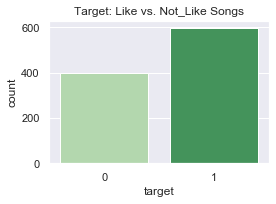

In [27]:
# Plot target variable 'like' counts
plt.figure(figsize=(4,3))
sns.countplot(x=song_target, 
              data=df,
              palette='Greens')
plt.title('Target: Like vs. Not_Like Songs', fontsize=12)
plt.tight_layout()
# target variable is very unbalanced

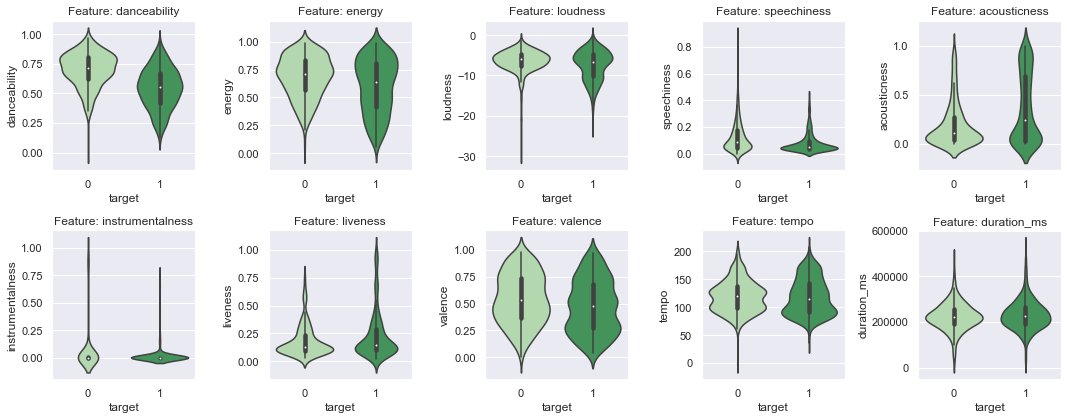

In [28]:
# Plot continuous features
ncol = 5
nrow = len(song_features_cont) / ncol
    
plt.figure(figsize=(15,6))
for i, feat in enumerate(song_features_cont):
    plt.subplot(nrow,ncol,i+1)
    sns.violinplot(y=feat, 
                   x=song_target,
                   data=df,
                   palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout()

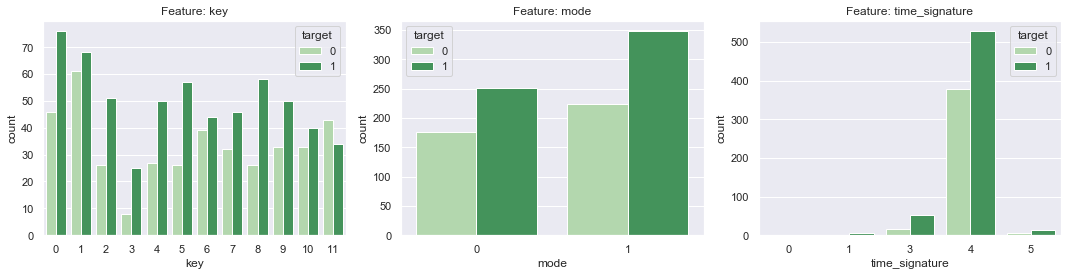

In [29]:
# Plot categorical features
ncol = len(song_features_cat)
nrow = 1

plt.figure(figsize=(15,4))
for i, feat in enumerate(song_features_cat):
    plt.subplot(nrow,ncol,i+1)
    sns.countplot(x=feat, 
                  data=df,
                  hue=song_target,
                  palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout()

#### string columns
- id	-string-	The Spotify ID for the track.
- uri	-string-	The Spotify URI for the track.
- track_href	-string-	A link to the Web API endpoint providing full details of the track.
- analysis_url	-string-	An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.
- type	-string-	The object type: “audio_features”

In [30]:
strings = ['id', 'uri', 'track_href','analysis_uri','type']

In [31]:
audio_features = ['danceability','energy','loudness','speechiness','instrumentalness',
                  'liveness','valence','tempo','acousticness','key','mode','duration_ms','time_signature']

In [32]:
def pos_neg(col):
    pos_ = df[df['target']==1][col]  
    neg_= df[df['target']==0][col]
    fig1 = plt.figure(figsize = (6,6))
    plt.title(f'Song {col}')
    pos_.hist(alpha = 0.7, bins = 30, label='positive',color='g',linewidth=1)
    neg_.hist(alpha = 0.7, bins=30,label='negative')
    plt.legend (loc = 'upper right')
    return plt.show()


- danceability	-float-	Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

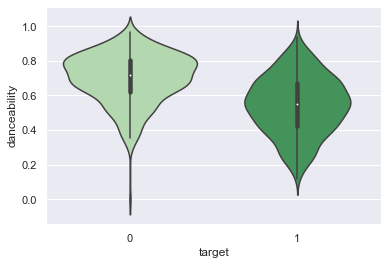

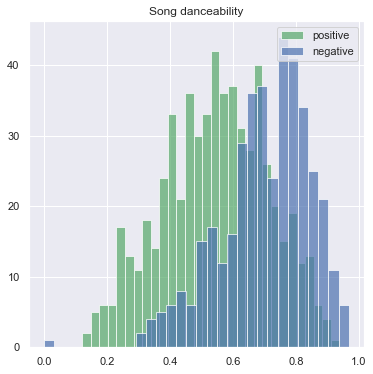

In [33]:
sns.violinplot(y='danceability', x='target',data=df,palette='Greens')
pos_neg('danceability')

- tempo	-float-	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The distribution of values for this feature look like this:Tempo distribution

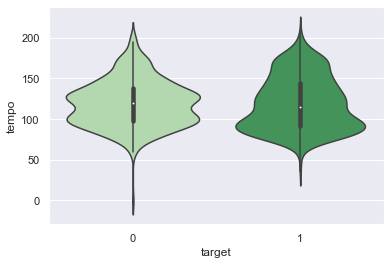

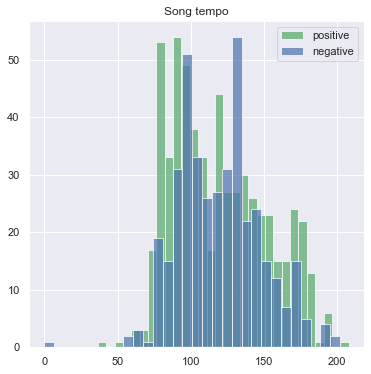

In [34]:
sns.violinplot(y='tempo', x='target',data=df,palette='Greens')
pos_neg('tempo')

- valence	-float-	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). The distribution of values for this feature look like this:Valence distribution


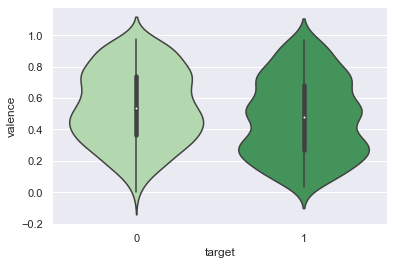

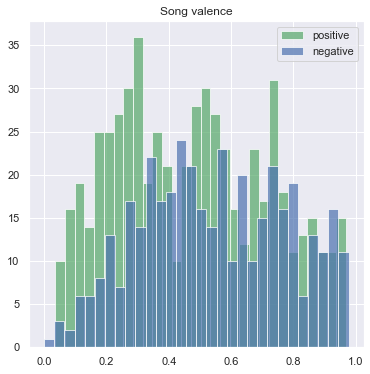

In [35]:
sns.violinplot(y='valence', x='target',data=df,palette='Greens')
pos_neg('valence')

- acousticness	-float-	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:Acousticness distribution

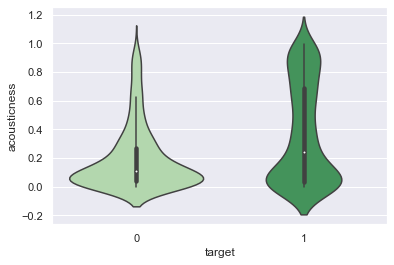

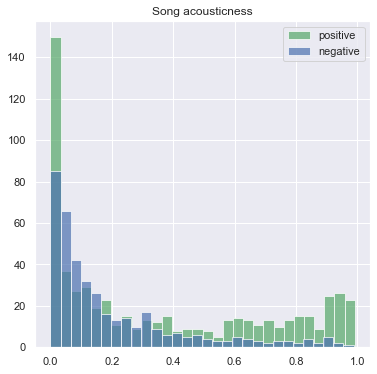

In [36]:
sns.violinplot(y='acousticness', x='target',data=df,palette='Greens')
pos_neg('acousticness')

- mode	-int-	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

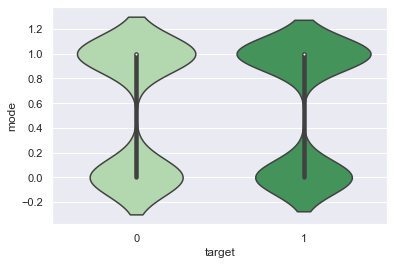

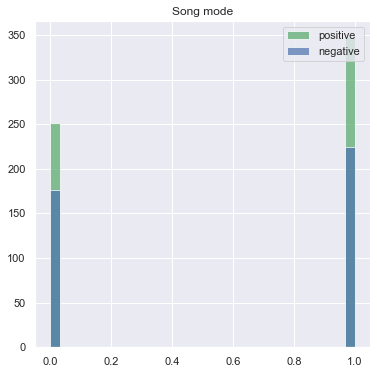

In [37]:
sns.violinplot(y='mode', x='target',data=df,palette='Greens')
pos_neg('mode')

- energy	-float-	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

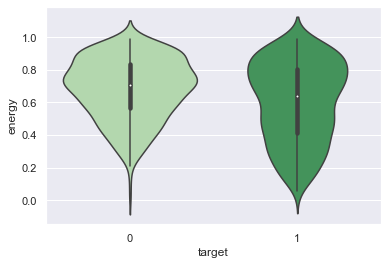

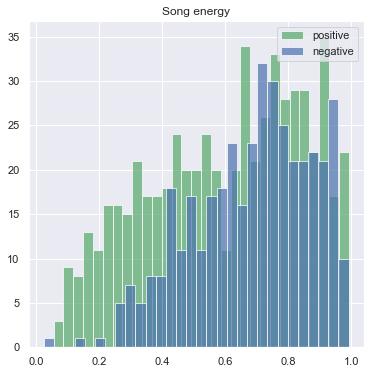

In [38]:
sns.violinplot(y='energy', x='target',data=df,palette='Greens')
pos_neg('energy')

- instrumentalness	-float-	Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

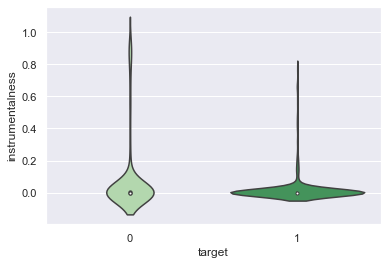

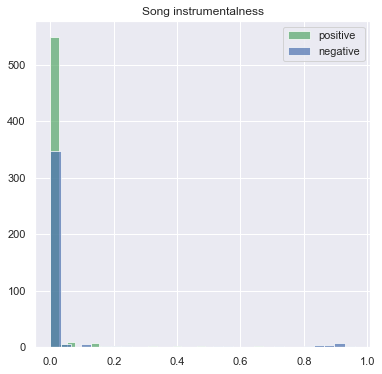

In [39]:
sns.violinplot(y='instrumentalness', x='target',data=df,palette='Greens')
pos_neg('instrumentalness')

- liveness	-float-	Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. The distribution of values for this feature look like this:Liveness distribution

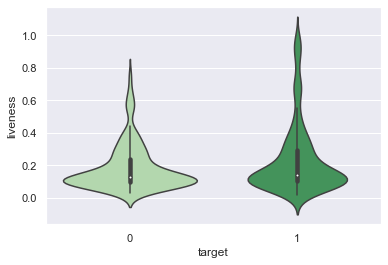

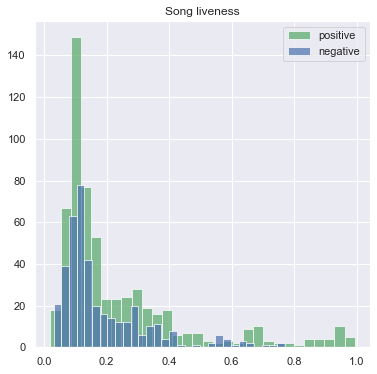

In [40]:
sns.violinplot(y='liveness', x='target',data=df,palette='Greens')
pos_neg('liveness')

- loudness	-float-	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. The distribution of values for this feature look like this:Loudness distribution

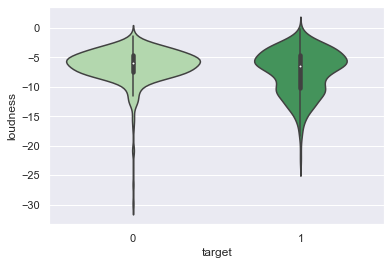

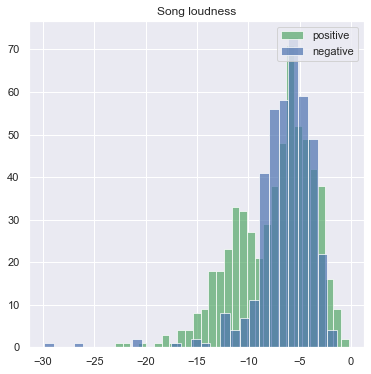

In [41]:
sns.violinplot(y='loudness', x='target',data=df,palette='Greens')
pos_neg('loudness')

- speechiness	-float-	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. The distribution of values for this feature look like this:Speechiness distribution

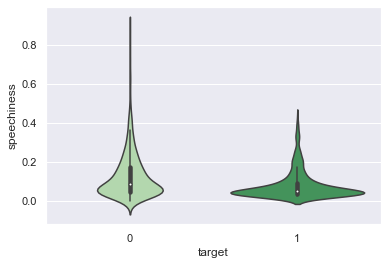

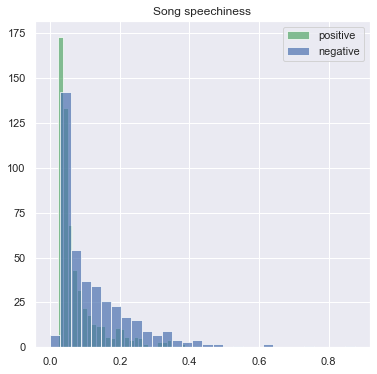

In [42]:
sns.violinplot(y='speechiness', x='target',data=df,palette='Greens')
pos_neg('speechiness')

- duration_ms	-int-	The duration of the track in milliseconds.

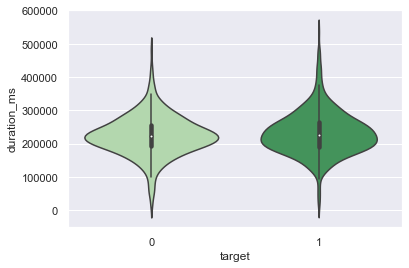

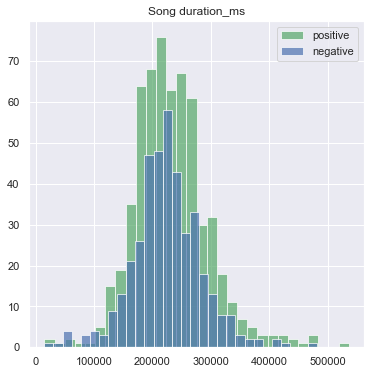

In [43]:
sns.violinplot(y='duration_ms', x='target',data=df,palette='Greens')
pos_neg('duration_ms')

- key	-int-	The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

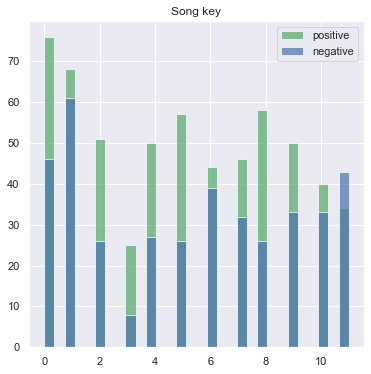

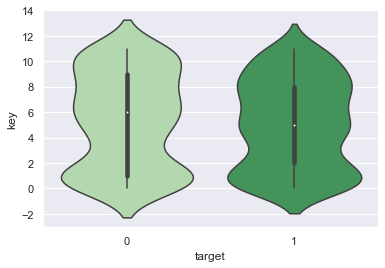

In [44]:
pos_neg('key')
sns.violinplot(y='key', x='target',data=df,palette='Greens')

- time_signature	-int-	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

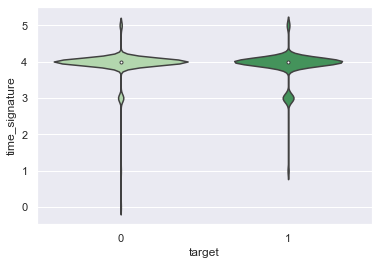

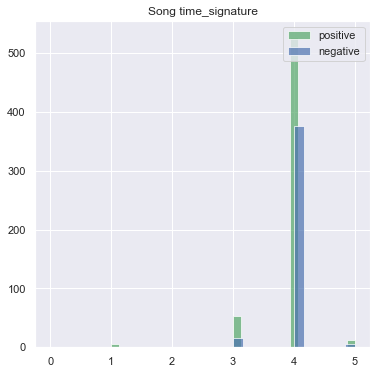

In [45]:
sns.violinplot(y='time_signature', x='target',data=df,palette='Greens')
pos_neg('time_signature')

- any relation between columns?

In [46]:
# Define function to perform mannwhitney test and get pvalue
# to identify which features have different distributions 
# when comparing like and not_like songs

def get_mannwhitney_p(group1, group2, features):
    pval_dict = {}
    for feat in features:
        stat, p = mannwhitneyu(group1[feat], group2[feat])
        pval_dict[feat] = p
    return pval_dict

# Split data by target 'like'
like = df[df['target']==1]
not_like = df[df['target']==0]

# Run test
mann_whit_results = get_mannwhitney_p(group1=like, 
                                      group2=not_like, 
                                      features=song_features_cont)

# Return features with pvalue < 0.05
p_dict = { key:value for (key,value) in mann_whit_results.items() if value < 0.05 }
sort_p = pd.DataFrame(sorted(p_dict.items(), key=lambda x: x[1], reverse=False))
sort_p.columns = ['feature','pvalue']
print(f'Significant Features:\n\n {sort_p}')
# 10 significant features


Significant Features:

             feature        pvalue
0      danceability  2.005800e-45
1       speechiness  2.708129e-17
2      acousticness  3.108409e-08
3            energy  5.366387e-07
4           valence  4.255038e-06
5          loudness  2.724966e-05
6          liveness  1.778741e-03
7  instrumentalness  3.129358e-02


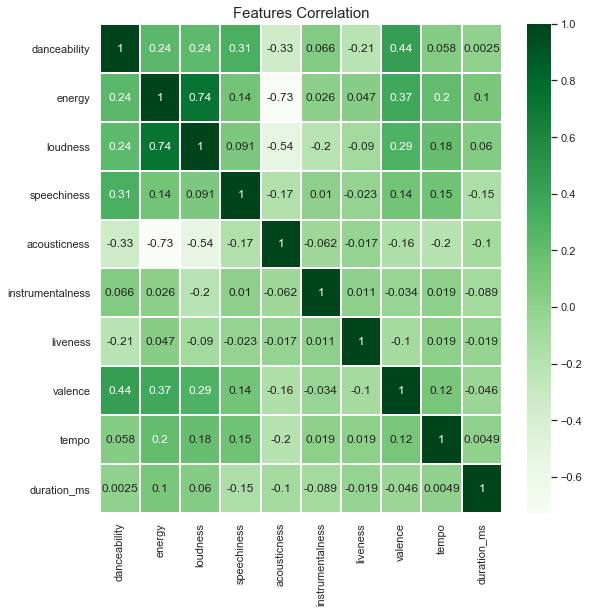

In [48]:
# Correlation plot - Heatmap
corr=df[song_features_cont].corr()
ax = plt.figure(figsize=(9,9))
sns.heatmap(corr,
            annot=True,
            linewidths=1,
            cmap="Greens")
#sns.palplot(sns.color_palette("BuGn_r"))
plt.title("Features Correlation",size=15)
plt.show()

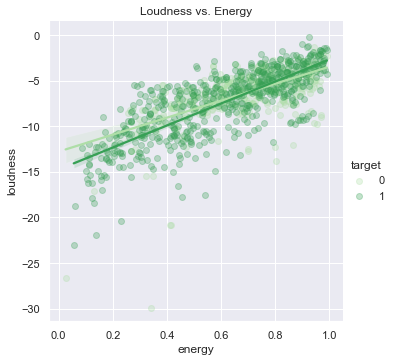

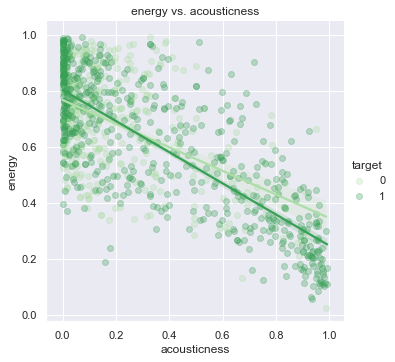

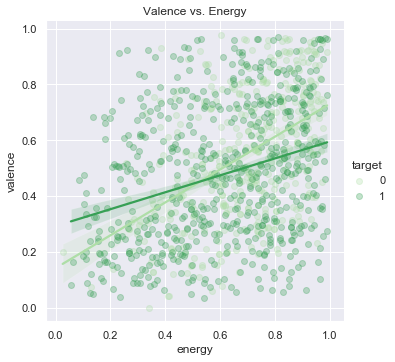

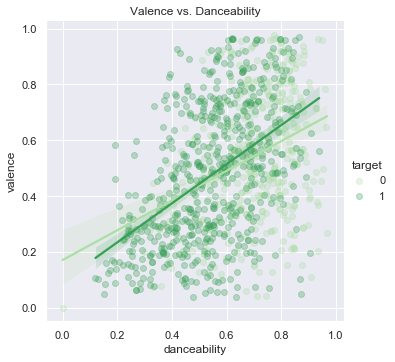

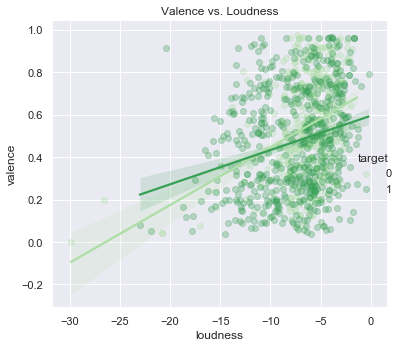

In [49]:
#loudness vs energy
sns.lmplot(y='loudness',x='energy',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Loudness vs. Energy')
#energy vs acousticness
sns.lmplot(y='energy',x='acousticness',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('energy vs. acousticness')
# Valence and Energy
sns.lmplot(y='valence',x='energy',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Valence vs. Energy')
# Valence and Danceability
sns.lmplot(y='valence',x='danceability',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Valence vs. Danceability')
# Valence and Loudness
sns.lmplot(y='valence',x='loudness',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Valence vs. Loudness')
plt.tight_layout()

In [50]:
# PCA for dimensionality reduction and visualization

# Feature's scaling
# Initializing scaler
scaler = StandardScaler()
# Separating features from target ('like')
songs_df_std = df[song_features_cont+song_features_cat].values
y = df[song_target].values
# Standardizing features
songs_df_std = StandardScaler().fit_transform(songs_df_std)

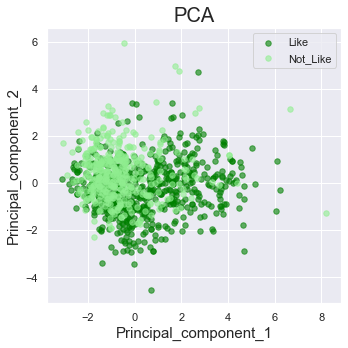

In [51]:
# PCA - Data projection in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(songs_df_std)
principal_df = pd.DataFrame(data = principal_components, 
                            columns = ['principal component 1', 'principal component 2'])
# Concatenate std features and target ('like')
songs_df_std_target = pd.concat([principal_df, df[[song_target]]], 
                                axis = 1)

# Plot 2D PCA
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal_component_1', fontsize = 15)
ax.set_ylabel('Principal_component_2', fontsize = 15)
targets = [1, 0]
colors = ['green', 'lightgreen']
for target, color in zip(targets, colors):
    idx = songs_df_std_target['target'] == target
    ax.scatter(songs_df_std_target.loc[idx, 'principal component 1'], 
               songs_df_std_target.loc[idx, 'principal component 2'], 
               c = color,
               s = 30,
               alpha=0.6
              )
ax.legend(['Like','Not_Like'])
plt.title('PCA', fontsize = 20)
plt.tight_layout()


In [52]:
#Explained Variance by the two first principal components
pca.explained_variance_ratio_

array([0.22608798, 0.10884455])

## models

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [55]:
# Model 1. Baseline Model - Logistic regression - All features

# Get features X and target y
X, y = df[song_features_cont+song_features_cat], df[song_target]

# Define evaluation procedure - 3-Fold cross validation
cross_val = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

# Instantiate model
logistic_model = LogisticRegression()


# Fit and evaluate model with all
# use standardized data
logit_scores = cross_val_score(logistic_model, X, y, scoring='f1', cv=cross_val, n_jobs=-1)


# Summarize performance - ROC AUC - Add more metrics!
print(f'Mean f1-score: {logit_scores.mean()}')

# Create f1_score dict - To save models performance
f1_score = {}

# Add to f1_score dict
f1_score['logistic_baseline'] = logit_scores.mean()

Mean f1-score: 0.7489285564057884


In [56]:
# Model 2. Decision Tree

# Instantiate model
tree_model = DecisionTreeClassifier(max_depth=5)

# Fit and evaluate model with all features
tree_scores = cross_val_score(tree_model, 
                              X, 
                              y, 
                              scoring='f1', 
                              cv=cross_val, 
                              n_jobs=-1
                             )

# Summarize performance
print(f'Mean f1-score: {tree_scores.mean()}')

# Add to ROC AUC dict
f1_score['decision_tree'] = tree_scores.mean()

Mean f1-score: 0.757381417869602


In [57]:
# Model 3. Random Forest

# Instantiate model
rf_model = RandomForestClassifier(max_depth=5)


# Fit and evaluate model with all features
rf_scores = cross_val_score(rf_model, 
                            X,
                            y, 
                            scoring='f1', 
                            cv=cross_val, 
                            n_jobs=-1
                           )


# Summarize performance
print(f'Mean f1-score: {rf_scores.mean()}')

# Add to ROC AUC dict
f1_score['random_forest'] = rf_scores.mean()

Mean f1-score: 0.800651663337285


In [58]:
# Model 4. ADA Boost

# Instantiate model
ada_model = AdaBoostClassifier() #base_estimator = LogisticRegression()

# Fit and evaluate model with all features
ada_scores = cross_val_score(ada_model,
                             X, 
                             y, 
                             scoring='f1', 
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {ada_scores.mean()}')

# Add to ROC AUC dict
f1_score['ada_boost'] = ada_scores.mean()


Mean f1-score: 0.7853589037813663


In [59]:
# Model 5. XGBoost

# Instantiate model
xgb_model = XGBClassifier()

# Fit and evaluate model with all features
xgb_scores = cross_val_score(xgb_model, 
                             X, 
                             y, 
                             scoring='f1',
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {xgb_scores.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost'] = xgb_scores.mean()

Mean f1-score: 0.8012917424623399


In [60]:
# Model 6. XGBoost with hyperparameter tunning

# Instantiate model
xgb_model = XGBClassifier(subsample = 0.8838383838383839,
                          scale_pos_weight = 2.7602040816326525,
                          reg_lambda = 1.0918367346938775,
                          reg_alpha = 1.2959183673469385,
                          n_estimators = 223,
                          min_child_weight = 5,
                          max_depth = 4,
                          learning_rate = 0.05047405878882374,
                          gamma = 0,
                          colsample_bytree = 0.8111111111111111,
                          colsample_bylevel = 0.9)

# Fit and evaluate model with all features
xgb_scores = cross_val_score(xgb_model,
                             X, 
                             y, 
                             scoring='f1',
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {xgb_scores.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost_optim'] = xgb_scores.mean()


Mean f1-score: 0.8066772784586345


In [61]:

# Metric - f1_score
f1_score

{'logistic_baseline': 0.7489285564057884,
 'decision_tree': 0.757381417869602,
 'random_forest': 0.800651663337285,
 'ada_boost': 0.7853589037813663,
 'xg_boost': 0.8012917424623399,
 'xg_boost_optim': 0.8066772784586345}

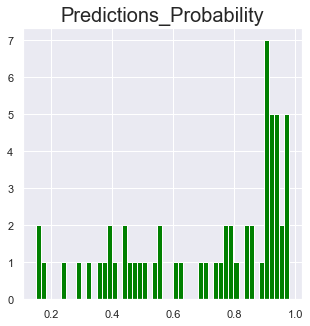

In [62]:
# Validation set
X_val = val[song_features_cont+song_features_cat]

# Model fit using all train data with all features
xgb_model.fit(X, y)

# Predictions on validation set data: 
predictions = xgb_model.predict(X_val)
predictions_prob = xgb_model.predict_proba(X_val)[:,1] #It returns prob of being zero or one, subselect second column (prob of being one)

# Plot
plt.figure(figsize=(5,5))
plt.hist(predictions_prob, 
         bins=50,
         color='green'
        )
plt.title('Predictions_Probability', fontsize = 20)
plt.show()

In [63]:
# Add predictions to validation df
discover_df_pred = val.copy()
discover_df_pred['like_prediction'] = predictions
discover_df_pred['like_probability'] = predictions_prob
discover_df_pred

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Discover,like_prediction,like_probability
0,0.554,0.3210,9,-8.251,1,0.0280,0.893000,0.000000,0.0996,0.2880,...,audio_features,6QPKYGnAW9QozVz2dSWqRg,spotify:track:6QPKYGnAW9QozVz2dSWqRg,https://api.spotify.com/v1/tracks/6QPKYGnAW9Qo...,https://api.spotify.com/v1/audio-analysis/6QPK...,285240,4,1,1,0.938603
1,0.603,0.6700,2,-3.882,0,0.0249,0.004080,0.000002,0.1120,0.4450,...,audio_features,5PKWUDfQFtc5qqo8cs1gQp,spotify:track:5PKWUDfQFtc5qqo8cs1gQp,https://api.spotify.com/v1/tracks/5PKWUDfQFtc5...,https://api.spotify.com/v1/audio-analysis/5PKW...,242974,4,1,1,0.966514
2,0.730,0.7700,8,-5.114,1,0.0298,0.138000,0.000000,0.0473,0.5070,...,audio_features,1eq1wUnLVLg4pdEfx9kajC,spotify:track:1eq1wUnLVLg4pdEfx9kajC,https://api.spotify.com/v1/tracks/1eq1wUnLVLg4...,https://api.spotify.com/v1/audio-analysis/1eq1...,228093,4,1,1,0.778625
3,0.612,0.7480,0,-5.014,1,0.0445,0.617000,0.000000,0.1670,0.5740,...,audio_features,50yHVBbU6M4iIfqBI1bxWx,spotify:track:50yHVBbU6M4iIfqBI1bxWx,https://api.spotify.com/v1/tracks/50yHVBbU6M4i...,https://api.spotify.com/v1/audio-analysis/50yH...,223267,4,1,1,0.904277
4,0.590,0.8330,5,-6.503,0,0.0615,0.014200,0.000005,0.1050,0.5370,...,audio_features,5jRMDFLiQaa4PKfabTMNYQ,spotify:track:5jRMDFLiQaa4PKfabTMNYQ,https://api.spotify.com/v1/tracks/5jRMDFLiQaa4...,https://api.spotify.com/v1/audio-analysis/5jRM...,240439,4,1,1,0.911428
5,0.496,0.8630,9,-4.153,1,0.0381,0.004600,0.000000,0.6390,0.2430,...,audio_features,2nLtzopw4rPReszdYBJU6h,spotify:track:2nLtzopw4rPReszdYBJU6h,https://api.spotify.com/v1/tracks/2nLtzopw4rPR...,https://api.spotify.com/v1/audio-analysis/2nLt...,185587,4,1,1,0.979860
6,0.528,0.4490,5,-6.250,0,0.0250,0.785000,0.000000,0.1220,0.3170,...,audio_features,56zZ48jdyY2oDXHVnwg5Di,spotify:track:56zZ48jdyY2oDXHVnwg5Di,https://api.spotify.com/v1/tracks/56zZ48jdyY2o...,https://api.spotify.com/v1/audio-analysis/56zZ...,261974,4,1,1,0.933226
7,0.394,0.6410,0,-6.493,0,0.0312,0.276000,0.000000,0.0958,0.3350,...,audio_features,5PvwPy5eRO8BPwpRzCHK3D,spotify:track:5PvwPy5eRO8BPwpRzCHK3D,https://api.spotify.com/v1/tracks/5PvwPy5eRO8B...,https://api.spotify.com/v1/audio-analysis/5Pvw...,390223,4,1,1,0.951887
8,0.645,0.5170,9,-6.708,0,0.0273,0.522000,0.000003,0.0905,0.2590,...,audio_features,6UgcN95w7vQxkR8sEFmwHG,spotify:track:6UgcN95w7vQxkR8sEFmwHG,https://api.spotify.com/v1/tracks/6UgcN95w7vQx...,https://api.spotify.com/v1/audio-analysis/6Ugc...,304900,4,1,1,0.932157
9,0.568,0.5080,9,-7.553,1,0.0333,0.737000,0.000000,0.1030,0.6850,...,audio_features,55eUtE9v3uatR0y0NijM6N,spotify:track:55eUtE9v3uatR0y0NijM6N,https://api.spotify.com/v1/tracks/55eUtE9v3uat...,https://api.spotify.com/v1/audio-analysis/55eU...,306512,4,1,1,0.848043


In [64]:
# Export predictions
discover_df_pred.to_csv('predictions.csv', index=False)

In [65]:
# Confusion matrix for validation set
from sklearn.metrics import confusion_matrix

# Import manual classification
y_true = discover_df_pred['Discover']
# Predictions
y_pred = discover_df_pred['like_prediction']

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f'True_Pos: {tp}\nFalse_Pos: {fp}\nFalse_Neg: {fn}\nTrue_Neg: {tn}')


True_Pos: 30
False_Pos: 14
False_Neg: 0
True_Neg: 16


In [66]:

# Calculate precision and recall
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: 0.6818181818181818
Recall: 1.0


In [67]:
# Calculate f1_score for validation data
#2*(precision*recall)/(precision + recall)
f1_score_val = f1_score(y_true, y_pred)
print(f'f1_score: {f1_score_val}')

TypeError: 'dict' object is not callable

In [26]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test=tts(df[audio_features],df['target'],test_size=0.2)

In [27]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
losses = {'logistic': {}}

In [28]:
def compute_classification_metrics(y_true, y_pred, threshold=0.5):
    y_pred_class = (y_pred > threshold).astype(int)
    metrics = {
        'logloss': log_loss(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_class),
        'fpr': confusion_matrix(y_true, y_pred_class, normalize='true')[0, 1],
        'tpr': confusion_matrix(y_true, y_pred_class, normalize='true')[1, 1],
        'precision': confusion_matrix(y_true, y_pred_class, normalize='pred')[1, 1],
        'roc_auc': roc_auc_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred_class),
    }
    return metrics

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]
losses['logistic'] = compute_classification_metrics(y_test, y_pred)
losses

{'logistic': {'logloss': 0.6664622311755675,
  'accuracy': 0.615,
  'fpr': 1.0,
  'tpr': 1.0,
  'precision': 0.615,
  'roc_auc': 0.5056488227219935,
  'f1_score': 0.7616099071207431}}

In [30]:
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier()
model2.fit(X_train,y_train)
y_pred = model2.predict_proba(X_test)[:, 1]
losses['tree_simple'] = compute_classification_metrics(y_test, y_pred)
losses['tree_simple']

{'logloss': 11.052520390011646,
 'accuracy': 0.68,
 'fpr': 0.36363636363636365,
 'tpr': 0.7073170731707317,
 'precision': 0.7565217391304347,
 'roc_auc': 0.6718403547671841,
 'f1_score': 0.7310924369747899}

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]
losses['random_forest'] = compute_classification_metrics(y_test, y_pred)
losses['random_forest']

{'logloss': 0.47284497185404845,
 'accuracy': 0.785,
 'fpr': 0.2857142857142857,
 'tpr': 0.8292682926829268,
 'precision': 0.8225806451612904,
 'roc_auc': 0.8437862950058072,
 'f1_score': 0.8259109311740891}

In [32]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict_proba(X_test)[:, 1]
losses['adaboost'] = compute_classification_metrics(y_test, y_pred)
pd.DataFrame(losses)

,logistic,tree_simple,random_forest,adaboost
logloss,0.666462,11.052520,0.472845,0.643315
accuracy,0.615000,0.680000,0.785000,0.765000
fpr,1.000000,0.363636,0.285714,0.272727
tpr,1.000000,0.707317,0.829268,0.788618
precision,0.615000,0.756522,0.822581,0.822034
roc_auc,0.505649,0.671840,0.843786,0.825150
f1_score,0.761610,0.731092,0.825911,0.804979


In [33]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]
losses['xgb'] = compute_classification_metrics(y_test, y_pred)
pd.DataFrame(losses)

,logistic,tree_simple,random_forest,adaboost,xgb
logloss,0.666462,11.052520,0.472845,0.643315,0.476268
accuracy,0.615000,0.680000,0.785000,0.765000,0.795000
fpr,1.000000,0.363636,0.285714,0.272727,0.298701
tpr,1.000000,0.707317,0.829268,0.788618,0.853659
precision,0.615000,0.756522,0.822581,0.822034,0.820312
roc_auc,0.505649,0.671840,0.843786,0.825150,0.842994
f1_score,0.761610,0.731092,0.825911,0.804979,0.836653


In [34]:
import lightgbm as lgb
import gc
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
losses['lgb'] = compute_classification_metrics(y_test, y_pred)
pd.DataFrame(losses)

,logistic,tree_simple,random_forest,adaboost,xgb,lgb
logloss,0.666462,11.052520,0.472845,0.643315,0.476268,0.598288
accuracy,0.615000,0.680000,0.785000,0.765000,0.795000,0.760000
fpr,1.000000,0.363636,0.285714,0.272727,0.298701,0.285714
tpr,1.000000,0.707317,0.829268,0.788618,0.853659,0.788618
precision,0.615000,0.756522,0.822581,0.822034,0.820312,0.815126
roc_auc,0.505649,0.671840,0.843786,0.825150,0.842994,0.869919
f1_score,0.761610,0.731092,0.825911,0.804979,0.836653,0.801653


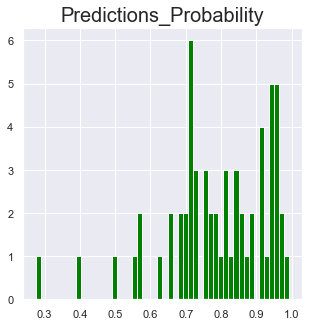

In [38]:
# Validation set
X_val = val[audio_features]

# Model fit using all train data with all features
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions on validation set data: 
predictions = xgb_model.predict(X_val)
predictions_prob = xgb_model.predict_proba(X_val)[:,1] #It returns prob of being zero or one, subselect second column (prob of being one)

# Plot
plt.figure(figsize=(5,5))
plt.hist(predictions_prob, 
         bins=50,
         color='green'
        )
plt.title('Predictions_Probability', fontsize = 20)
plt.show()

In [39]:
val_pred = val.copy()
val_pred['like_prediction'] = predictions
val_pred['like_probability'] = predictions_prob
val_pred

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,like_prediction,like_probability
0,0.312,0.7130,9,-4.489,1,0.0327,0.0258,0.000000,0.1350,0.1960,169.871,audio_features,0jh2HyqarexLFrEyN1dpKp,spotify:track:0jh2HyqarexLFrEyN1dpKp,https://api.spotify.com/v1/tracks/0jh2HyqarexL...,https://api.spotify.com/v1/audio-analysis/0jh2...,224200,4,1,0.886860
1,0.435,0.1640,3,-10.808,1,0.0374,0.9420,0.000000,0.0953,0.1960,113.173,audio_features,1IPFKODChktDPUestIg4ip,spotify:track:1IPFKODChktDPUestIg4ip,https://api.spotify.com/v1/tracks/1IPFKODChktD...,https://api.spotify.com/v1/audio-analysis/1IPF...,250276,4,1,0.930558
2,0.489,0.3600,10,-9.743,1,0.0267,0.7730,0.000000,0.1260,0.3560,82.036,audio_features,1GLv3fQgDw1QhctyM3O3VA,spotify:track:1GLv3fQgDw1QhctyM3O3VA,https://api.spotify.com/v1/tracks/1GLv3fQgDw1Q...,https://api.spotify.com/v1/audio-analysis/1GLv...,289087,4,1,0.953089
3,0.451,0.2130,0,-15.158,1,0.0310,0.8990,0.002210,0.1120,0.3070,105.630,audio_features,07Q46YQYMMDGeNa1aJlcYI,spotify:track:07Q46YQYMMDGeNa1aJlcYI,https://api.spotify.com/v1/tracks/07Q46YQYMMDG...,https://api.spotify.com/v1/audio-analysis/07Q4...,259200,4,1,0.920782
4,0.333,0.3180,3,-8.961,1,0.0335,0.7880,0.000000,0.1420,0.2730,94.899,audio_features,7j2uqDuCIGTVot0YKmHLUf,spotify:track:7j2uqDuCIGTVot0YKmHLUf,https://api.spotify.com/v1/tracks/7j2uqDuCIGTV...,https://api.spotify.com/v1/audio-analysis/7j2u...,244114,5,1,0.762790
5,0.563,0.4390,4,-7.780,1,0.0325,0.2950,0.000000,0.0952,0.1490,120.005,audio_features,7nZOFlTfSoR0z6tzqW8n50,spotify:track:7nZOFlTfSoR0z6tzqW8n50,https://api.spotify.com/v1/tracks/7nZOFlTfSoR0...,https://api.spotify.com/v1/audio-analysis/7nZO...,266947,4,1,0.576234
6,0.298,0.2630,5,-12.385,1,0.0284,0.7300,0.001120,0.1130,0.1620,89.991,audio_features,1aQjpy1uVpOJOKH47y0j0G,spotify:track:1aQjpy1uVpOJOKH47y0j0G,https://api.spotify.com/v1/tracks/1aQjpy1uVpOJ...,https://api.spotify.com/v1/audio-analysis/1aQj...,283377,4,1,0.975709
7,0.604,0.2610,0,-7.736,1,0.0598,0.8860,0.000000,0.1420,0.3610,77.245,audio_features,6pP5RJbBH6eKR8BCYX3MSU,spotify:track:6pP5RJbBH6eKR8BCYX3MSU,https://api.spotify.com/v1/tracks/6pP5RJbBH6eK...,https://api.spotify.com/v1/audio-analysis/6pP5...,232907,4,1,0.710932
8,0.673,0.4570,1,-6.200,1,0.0297,0.5080,0.000000,0.1210,0.1860,141.817,audio_features,0FVPOqIivjXR49CyJZAw7g,spotify:track:0FVPOqIivjXR49CyJZAw7g,https://api.spotify.com/v1/tracks/0FVPOqIivjXR...,https://api.spotify.com/v1/audio-analysis/0FVP...,265120,4,1,0.568429
9,0.548,0.4200,0,-7.842,1,0.0277,0.1980,0.000004,0.0899,0.1960,128.012,audio_features,7LwGBxB0h0CVmkOZxYKn0g,spotify:track:7LwGBxB0h0CVmkOZxYKn0g,https://api.spotify.com/v1/tracks/7LwGBxB0h0CV...,https://api.spotify.com/v1/audio-analysis/7LwG...,318909,4,1,0.653176
